## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp030'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 256 #224
    tile_size = 256 #224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 256, 256])

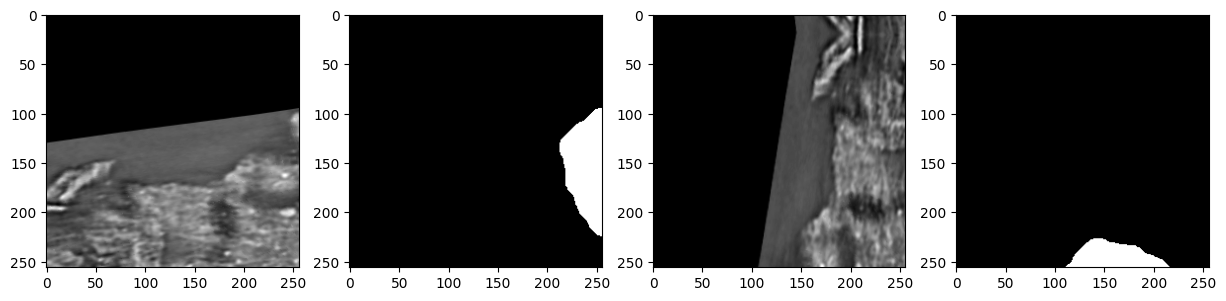

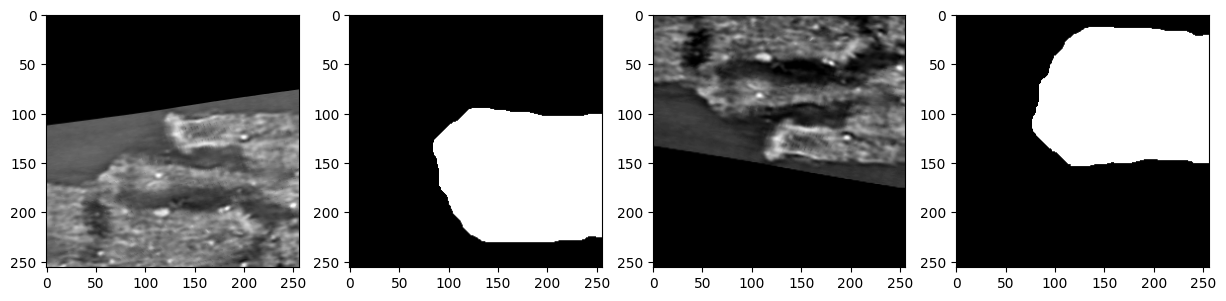

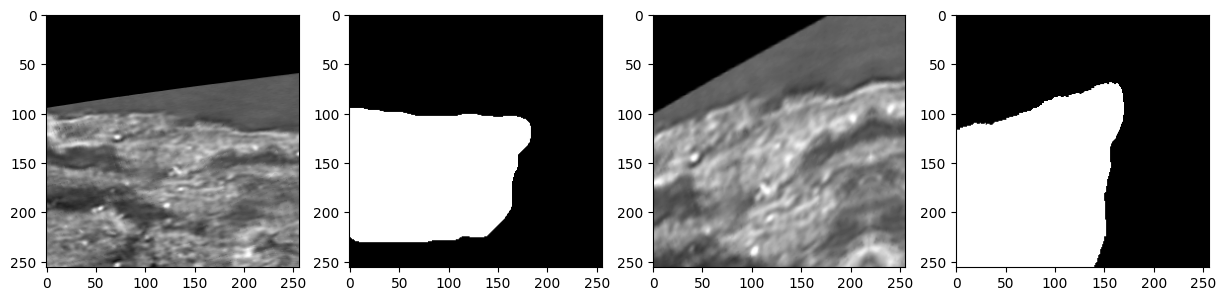

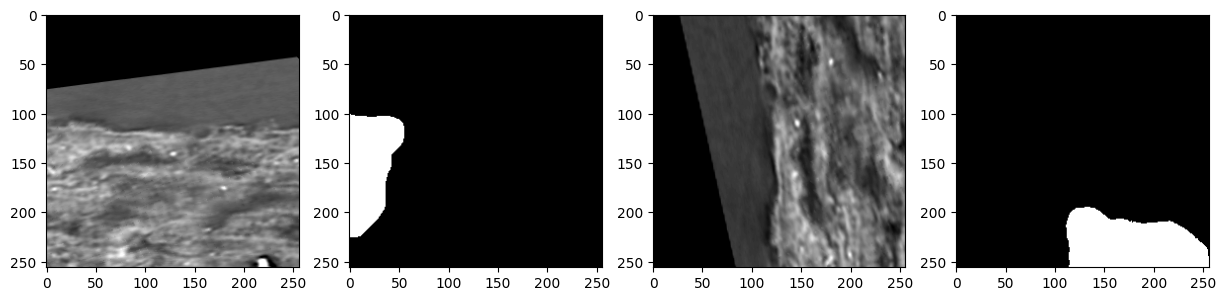

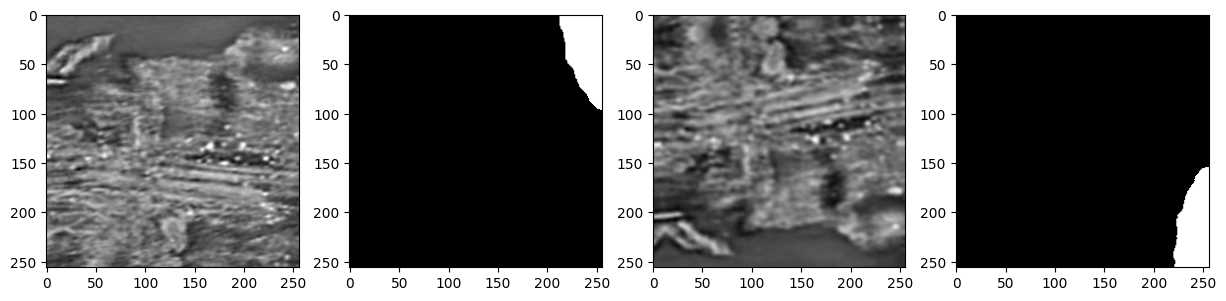

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

50694

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/344 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1421903161979625
th: 0.15, fbeta: 0.14214421009370196
th: 0.2, fbeta: 0.1419781819318383
th: 0.25, fbeta: 0.14160874689748698
th: 0.3, fbeta: 0.1840859357987852
th: 0.35, fbeta: 0.20579142157861727
th: 0.4, fbeta: 0.2211935789872611
th: 0.45, fbeta: 0.23409110885697101


best_th: 0.5, fbeta: 0.24136919277748764
Epoch 1 - avg_train_loss: 0.7058  avg_val_loss: 0.5479  time: 103s
Epoch 1 - avgScore: 0.2414
Epoch 1 - Save Best Score: 0.2414 Model
Epoch 1 - Save Best Loss: 0.5479 Model


th: 0.5, fbeta: 0.24136919277748764


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14220208307632404
th: 0.15, fbeta: 0.1421935057549581
th: 0.2, fbeta: 0.1429338072460154
th: 0.25, fbeta: 0.19840640034002385
th: 0.3, fbeta: 0.2182030699991655
th: 0.35, fbeta: 0.2464251926406007
th: 0.4, fbeta: 0.27510521133371346
th: 0.45, fbeta: 0.29391039810399344


best_th: 0.45, fbeta: 0.29391039810399344
Epoch 2 - avg_train_loss: 0.5086  avg_val_loss: 0.4526  time: 105s
Epoch 2 - avgScore: 0.2939
Epoch 2 - Save Best Score: 0.2939 Model
Epoch 2 - Save Best Loss: 0.4526 Model


th: 0.5, fbeta: 0.2861900096937243


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.30131367594713565
th: 0.15, fbeta: 0.3472728972166205
th: 0.2, fbeta: 0.3390405735518081
th: 0.25, fbeta: 0.30370660407252403
th: 0.3, fbeta: 0.2577353973511759
th: 0.35, fbeta: 0.21293346218199105
th: 0.4, fbeta: 0.17002485541118909
th: 0.45, fbeta: 0.13101663871057664


best_th: 0.15, fbeta: 0.3472728972166205
Epoch 3 - avg_train_loss: 0.3093  avg_val_loss: 0.3296  time: 106s
Epoch 3 - avgScore: 0.3473
Epoch 3 - Save Best Score: 0.3473 Model
Epoch 3 - Save Best Loss: 0.3296 Model


th: 0.5, fbeta: 0.0935455210815781


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3721288291200739
th: 0.15, fbeta: 0.3940488356444085
th: 0.2, fbeta: 0.37203186899153534
th: 0.25, fbeta: 0.33715889243483393
th: 0.3, fbeta: 0.2986910952295784
th: 0.35, fbeta: 0.2603603405456843
th: 0.4, fbeta: 0.21867657395983342
th: 0.45, fbeta: 0.17999009902577473


best_th: 0.15, fbeta: 0.3940488356444085
Epoch 4 - avg_train_loss: 0.2126  avg_val_loss: 0.3549  time: 106s
Epoch 4 - avgScore: 0.3940
Epoch 4 - Save Best Score: 0.3940 Model
Epoch 4 - Save Best Loss: 0.3549 Model


th: 0.5, fbeta: 0.14350257265135644


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38873332366278607
th: 0.15, fbeta: 0.3916316749779907
th: 0.2, fbeta: 0.36110339447923523
th: 0.25, fbeta: 0.318193175048812
th: 0.3, fbeta: 0.27758110483377096
th: 0.35, fbeta: 0.23622486025575792
th: 0.4, fbeta: 0.19453708685469248
th: 0.45, fbeta: 0.1583916857077037


best_th: 0.15, fbeta: 0.3916316749779907
Epoch 5 - avg_train_loss: 0.1915  avg_val_loss: 0.3605  time: 106s
Epoch 5 - avgScore: 0.3916


th: 0.5, fbeta: 0.12502019710235632


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3994257693023641
th: 0.15, fbeta: 0.4024061107241228
th: 0.2, fbeta: 0.3934564064995002
th: 0.25, fbeta: 0.37720115431854545
th: 0.3, fbeta: 0.3539735568502516
th: 0.35, fbeta: 0.3271281486930482
th: 0.4, fbeta: 0.2967631408731736
th: 0.45, fbeta: 0.2649418339885677


best_th: 0.15, fbeta: 0.4024061107241228
Epoch 6 - avg_train_loss: 0.1759  avg_val_loss: 0.4031  time: 106s
Epoch 6 - avgScore: 0.4024
Epoch 6 - Save Best Score: 0.4024 Model
Epoch 6 - Save Best Loss: 0.4031 Model


th: 0.5, fbeta: 0.2315940278431246


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2838086262038668
th: 0.15, fbeta: 0.25305155293440273
th: 0.2, fbeta: 0.2169330810181601
th: 0.25, fbeta: 0.1832393991564971
th: 0.3, fbeta: 0.14777153732701429
th: 0.35, fbeta: 0.1179712259727557
th: 0.4, fbeta: 0.09392593331578263
th: 0.45, fbeta: 0.07359853177848248


best_th: 0.1, fbeta: 0.2838086262038668
Epoch 7 - avg_train_loss: 0.1655  avg_val_loss: 0.4773  time: 107s
Epoch 7 - avgScore: 0.2838


th: 0.5, fbeta: 0.05900783448068942


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3882983999259169
th: 0.15, fbeta: 0.40231538777385367
th: 0.2, fbeta: 0.40127220182141415
th: 0.25, fbeta: 0.3899044842293669
th: 0.3, fbeta: 0.3742862559521164
th: 0.35, fbeta: 0.3569325313543243
th: 0.4, fbeta: 0.33647334223780667
th: 0.45, fbeta: 0.3131226241785904


best_th: 0.15, fbeta: 0.40231538777385367
Epoch 8 - avg_train_loss: 0.1531  avg_val_loss: 0.4212  time: 106s
Epoch 8 - avgScore: 0.4023


th: 0.5, fbeta: 0.28651880480342695


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37738452693457597
th: 0.15, fbeta: 0.3705381983726723
th: 0.2, fbeta: 0.35683518560408656
th: 0.25, fbeta: 0.33756592214190156
th: 0.3, fbeta: 0.31414547856146513
th: 0.35, fbeta: 0.2872762860818289
th: 0.4, fbeta: 0.26184657720449434
th: 0.45, fbeta: 0.23478411393385082


best_th: 0.1, fbeta: 0.37738452693457597
Epoch 9 - avg_train_loss: 0.1444  avg_val_loss: 0.4517  time: 106s
Epoch 9 - avgScore: 0.3774


th: 0.5, fbeta: 0.20721597066676023


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36419528928265604
th: 0.15, fbeta: 0.36077865910038887
th: 0.2, fbeta: 0.35313703613181135
th: 0.25, fbeta: 0.337823214889867
th: 0.3, fbeta: 0.31736347187618996
th: 0.35, fbeta: 0.2938002673330423
th: 0.4, fbeta: 0.269460850152093
th: 0.45, fbeta: 0.2425882730149132


best_th: 0.1, fbeta: 0.36419528928265604
Epoch 10 - avg_train_loss: 0.1308  avg_val_loss: 0.4729  time: 107s
Epoch 10 - avgScore: 0.3642


th: 0.5, fbeta: 0.213467732594127


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.358252612537647
th: 0.15, fbeta: 0.3610859144505655
th: 0.2, fbeta: 0.3563526946261194
th: 0.25, fbeta: 0.3471407474897842
th: 0.3, fbeta: 0.3326741949042357
th: 0.35, fbeta: 0.3146144797180987
th: 0.4, fbeta: 0.2935447328757506
th: 0.45, fbeta: 0.26780859320397316


best_th: 0.15, fbeta: 0.3610859144505655
Epoch 11 - avg_train_loss: 0.1255  avg_val_loss: 0.4534  time: 107s
Epoch 11 - avgScore: 0.3611


th: 0.5, fbeta: 0.24056545572526042


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2719097729912898
th: 0.15, fbeta: 0.21775744258621058
th: 0.2, fbeta: 0.17573841234280857
th: 0.25, fbeta: 0.14199827704790285
th: 0.3, fbeta: 0.11442463452029035
th: 0.35, fbeta: 0.09164272218943409
th: 0.4, fbeta: 0.07447753559292206
th: 0.45, fbeta: 0.05975087557450965


best_th: 0.1, fbeta: 0.2719097729912898
Epoch 12 - avg_train_loss: 0.1178  avg_val_loss: 0.5359  time: 105s
Epoch 12 - avgScore: 0.2719


th: 0.5, fbeta: 0.047534433206578255


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32704268715440876
th: 0.15, fbeta: 0.3071888049675831
th: 0.2, fbeta: 0.2876325451097734
th: 0.25, fbeta: 0.2682438642548079
th: 0.3, fbeta: 0.2464984809702836
th: 0.35, fbeta: 0.22491885523292884
th: 0.4, fbeta: 0.2034693518322446
th: 0.45, fbeta: 0.18128430452197775


best_th: 0.1, fbeta: 0.32704268715440876
Epoch 13 - avg_train_loss: 0.1067  avg_val_loss: 0.5706  time: 105s
Epoch 13 - avgScore: 0.3270


th: 0.5, fbeta: 0.15935748643076375


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34850833448428287
th: 0.15, fbeta: 0.33743615054480347
th: 0.2, fbeta: 0.3231150960325932
th: 0.25, fbeta: 0.3076487918544838
th: 0.3, fbeta: 0.293098809827571
th: 0.35, fbeta: 0.27814584956785143
th: 0.4, fbeta: 0.2628647739644199
th: 0.45, fbeta: 0.2455395852647408


best_th: 0.1, fbeta: 0.34850833448428287
Epoch 14 - avg_train_loss: 0.1054  avg_val_loss: 0.5456  time: 105s
Epoch 14 - avgScore: 0.3485


th: 0.5, fbeta: 0.2258122402950595


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.287801208809599
th: 0.15, fbeta: 0.2692855913672347
th: 0.2, fbeta: 0.25029458329317056
th: 0.25, fbeta: 0.228805599697433
th: 0.3, fbeta: 0.2068431720437297
th: 0.35, fbeta: 0.188816566854061
th: 0.4, fbeta: 0.17158058427246256
th: 0.45, fbeta: 0.15448738897656789


best_th: 0.1, fbeta: 0.287801208809599
Epoch 15 - avg_train_loss: 0.0967  avg_val_loss: 0.6561  time: 105s
Epoch 15 - avgScore: 0.2878


th: 0.5, fbeta: 0.1380156160086727


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26780377324316695
th: 0.15, fbeta: 0.25065105628692075
th: 0.2, fbeta: 0.22540136170539402
th: 0.25, fbeta: 0.20244864237509833
th: 0.3, fbeta: 0.18139473514624174
th: 0.35, fbeta: 0.1561998556024039
th: 0.4, fbeta: 0.13327202176799188
th: 0.45, fbeta: 0.11501673079721522


best_th: 0.1, fbeta: 0.26780377324316695
Epoch 16 - avg_train_loss: 0.0933  avg_val_loss: 0.6462  time: 105s
Epoch 16 - avgScore: 0.2678


th: 0.5, fbeta: 0.09892687843028954


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3010000948976362
th: 0.15, fbeta: 0.2890759204651007
th: 0.2, fbeta: 0.2738700168920861
th: 0.25, fbeta: 0.2564394884562164
th: 0.3, fbeta: 0.23743492534855318
th: 0.35, fbeta: 0.21896900934551752
th: 0.4, fbeta: 0.20139008632590416
th: 0.45, fbeta: 0.18330877930170378


best_th: 0.1, fbeta: 0.3010000948976362
Epoch 17 - avg_train_loss: 0.0868  avg_val_loss: 0.6087  time: 106s
Epoch 17 - avgScore: 0.3010


th: 0.5, fbeta: 0.16437132849078215


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3413679190974749
th: 0.15, fbeta: 0.325626103083554
th: 0.2, fbeta: 0.3072108298135827
th: 0.25, fbeta: 0.2856715468650842
th: 0.3, fbeta: 0.26215780942099637
th: 0.35, fbeta: 0.23925201403121335
th: 0.4, fbeta: 0.2159832931714377
th: 0.45, fbeta: 0.1930502401933928


best_th: 0.1, fbeta: 0.3413679190974749
Epoch 18 - avg_train_loss: 0.0822  avg_val_loss: 0.6306  time: 106s
Epoch 18 - avgScore: 0.3414


th: 0.5, fbeta: 0.17093953991931576


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.280314677050557
th: 0.15, fbeta: 0.2573798049524664
th: 0.2, fbeta: 0.2358079123281542
th: 0.25, fbeta: 0.21350546853331923
th: 0.3, fbeta: 0.1935590821995324
th: 0.35, fbeta: 0.17454863428240142
th: 0.4, fbeta: 0.15615536411247585
th: 0.45, fbeta: 0.13834669306235428


best_th: 0.1, fbeta: 0.280314677050557
Epoch 19 - avg_train_loss: 0.0770  avg_val_loss: 0.6689  time: 106s
Epoch 19 - avgScore: 0.2803


th: 0.5, fbeta: 0.11956524442048218


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.280183079078887
th: 0.15, fbeta: 0.2565259431896684
th: 0.2, fbeta: 0.2317216510405982
th: 0.25, fbeta: 0.20548914642776991
th: 0.3, fbeta: 0.1800657899170391
th: 0.35, fbeta: 0.15782720600496708
th: 0.4, fbeta: 0.1374903845856702
th: 0.45, fbeta: 0.11848276811852827


best_th: 0.1, fbeta: 0.280183079078887
Epoch 20 - avg_train_loss: 0.0727  avg_val_loss: 0.6858  time: 106s
Epoch 20 - avgScore: 0.2802


th: 0.5, fbeta: 0.10021751987585338


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28216056740950124
th: 0.15, fbeta: 0.25900040894013415
th: 0.2, fbeta: 0.23563919907466954
th: 0.25, fbeta: 0.21162386413886158
th: 0.3, fbeta: 0.18888487237863594
th: 0.35, fbeta: 0.16830055718509826
th: 0.4, fbeta: 0.1494972690375716
th: 0.45, fbeta: 0.1299948471735058


best_th: 0.1, fbeta: 0.28216056740950124
Epoch 21 - avg_train_loss: 0.0700  avg_val_loss: 0.6993  time: 106s
Epoch 21 - avgScore: 0.2822


th: 0.5, fbeta: 0.11304777235773636


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31880280790660476
th: 0.15, fbeta: 0.2950184703231475
th: 0.2, fbeta: 0.2693909792906902
th: 0.25, fbeta: 0.245134808344106
th: 0.3, fbeta: 0.22165038557883598
th: 0.35, fbeta: 0.19619573832619902
th: 0.4, fbeta: 0.17222374678262029
th: 0.45, fbeta: 0.1498055150516684


best_th: 0.1, fbeta: 0.31880280790660476
Epoch 22 - avg_train_loss: 0.0676  avg_val_loss: 0.6981  time: 107s
Epoch 22 - avgScore: 0.3188


th: 0.5, fbeta: 0.12952496872353586


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26351861524304276
th: 0.15, fbeta: 0.2333333019900871
th: 0.2, fbeta: 0.20511640232417586
th: 0.25, fbeta: 0.18212661391801202
th: 0.3, fbeta: 0.16116582594166962
th: 0.35, fbeta: 0.14026469951901932
th: 0.4, fbeta: 0.1221284971351849
th: 0.45, fbeta: 0.1054086775874345


best_th: 0.1, fbeta: 0.26351861524304276
Epoch 23 - avg_train_loss: 0.0645  avg_val_loss: 0.7277  time: 106s
Epoch 23 - avgScore: 0.2635


th: 0.5, fbeta: 0.08896890856749795


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2929010459035714
th: 0.15, fbeta: 0.2727952064183464
th: 0.2, fbeta: 0.2517018249046097
th: 0.25, fbeta: 0.2306353336858775
th: 0.3, fbeta: 0.2100507609828017
th: 0.35, fbeta: 0.18852012511580915
th: 0.4, fbeta: 0.1671276465191277
th: 0.45, fbeta: 0.14779566676214934


best_th: 0.1, fbeta: 0.2929010459035714
Epoch 24 - avg_train_loss: 0.0599  avg_val_loss: 0.7142  time: 106s
Epoch 24 - avgScore: 0.2929


th: 0.5, fbeta: 0.12881050484708362


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28000017562457535
th: 0.15, fbeta: 0.2530813547251514
th: 0.2, fbeta: 0.22771499283330088
th: 0.25, fbeta: 0.2042468639697983
th: 0.3, fbeta: 0.181178953153941
th: 0.35, fbeta: 0.1614282757472619
th: 0.4, fbeta: 0.1431499854442373
th: 0.45, fbeta: 0.12571381988115318


best_th: 0.1, fbeta: 0.28000017562457535
Epoch 25 - avg_train_loss: 0.0592  avg_val_loss: 0.7391  time: 106s
Epoch 25 - avgScore: 0.2800


th: 0.5, fbeta: 0.10846400913419127


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3108523984692649
th: 0.15, fbeta: 0.29229480564131755
th: 0.2, fbeta: 0.26926909598220033
th: 0.25, fbeta: 0.24753062351522181
th: 0.3, fbeta: 0.22499157346724855
th: 0.35, fbeta: 0.20080118104750172
th: 0.4, fbeta: 0.1782692205325592
th: 0.45, fbeta: 0.1589316067509698


best_th: 0.1, fbeta: 0.3108523984692649
Epoch 26 - avg_train_loss: 0.0592  avg_val_loss: 0.7401  time: 106s
Epoch 26 - avgScore: 0.3109


th: 0.5, fbeta: 0.13867540437794704


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30857661238664574
th: 0.15, fbeta: 0.29036940675175177
th: 0.2, fbeta: 0.2706257303207977
th: 0.25, fbeta: 0.2500474717952356
th: 0.3, fbeta: 0.2294903230713099
th: 0.35, fbeta: 0.20918348258869418
th: 0.4, fbeta: 0.19043506082756548
th: 0.45, fbeta: 0.1727253931006352


best_th: 0.1, fbeta: 0.30857661238664574
Epoch 27 - avg_train_loss: 0.0568  avg_val_loss: 0.7244  time: 106s
Epoch 27 - avgScore: 0.3086


th: 0.5, fbeta: 0.15322949345508158


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3112075301750839
th: 0.15, fbeta: 0.2928669248649565
th: 0.2, fbeta: 0.2719383820636891
th: 0.25, fbeta: 0.24856343530373975
th: 0.3, fbeta: 0.225772413237138
th: 0.35, fbeta: 0.2028650584820605
th: 0.4, fbeta: 0.18130883894370164
th: 0.45, fbeta: 0.16167478853017275


best_th: 0.1, fbeta: 0.3112075301750839
Epoch 28 - avg_train_loss: 0.0555  avg_val_loss: 0.7031  time: 107s
Epoch 28 - avgScore: 0.3112


th: 0.5, fbeta: 0.14215382921435415


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3138685029656148
th: 0.15, fbeta: 0.2956385792876426
th: 0.2, fbeta: 0.2759191896757546
th: 0.25, fbeta: 0.2551243431030734
th: 0.3, fbeta: 0.2331635473202113
th: 0.35, fbeta: 0.21103134635277052
th: 0.4, fbeta: 0.19049820562229672
th: 0.45, fbeta: 0.17040752784177252


best_th: 0.1, fbeta: 0.3138685029656148
Epoch 29 - avg_train_loss: 0.0564  avg_val_loss: 0.7388  time: 107s
Epoch 29 - avgScore: 0.3139


th: 0.5, fbeta: 0.148865268720706


  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3057789795605667
th: 0.15, fbeta: 0.2872815386490035
th: 0.2, fbeta: 0.266882510996606
th: 0.25, fbeta: 0.24632920063109856
th: 0.3, fbeta: 0.22461306830867778
th: 0.35, fbeta: 0.20311661667883021
th: 0.4, fbeta: 0.18230240683261126
th: 0.45, fbeta: 0.16150986787171995


best_th: 0.1, fbeta: 0.3057789795605667
Epoch 30 - avg_train_loss: 0.0548  avg_val_loss: 0.7422  time: 106s
Epoch 30 - avgScore: 0.3058


th: 0.5, fbeta: 0.1397859280703063


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3994257693023641
th: 0.15, fbeta: 0.4024061107241228
th: 0.2, fbeta: 0.3934564064995002
th: 0.25, fbeta: 0.37720115431854545
th: 0.3, fbeta: 0.3539735568502516
th: 0.35, fbeta: 0.3271281486930482
th: 0.4, fbeta: 0.2967631408731736
th: 0.45, fbeta: 0.2649418339885677


best_th: 0.15, fbeta: 0.4024061107241228


th: 0.5, fbeta: 0.2315940278431246


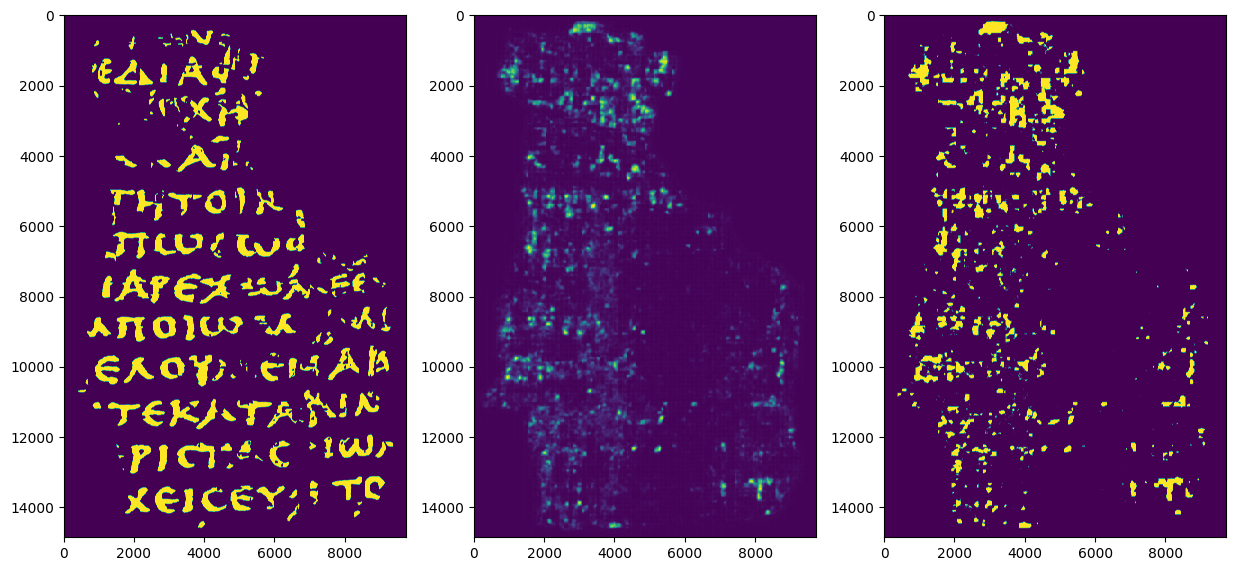

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.20868117e+08, 1.04304950e+07, 4.17573000e+06, 2.19020900e+06,
        1.40373300e+06, 1.00284100e+06, 7.69904000e+05, 6.24822000e+05,
        5.17736000e+05, 4.42884000e+05, 3.84195000e+05, 3.37038000e+05,
        2.94362000e+05, 2.63865000e+05, 2.30326000e+05, 1.97164000e+05,
        1.42135000e+05, 9.80200000e+04, 5.36170000e+04, 1.41510000e+04]),
 array([1.06150690e-07, 4.66785068e-02, 9.33569075e-02, 1.40035308e-01,
        1.86713709e-01, 2.33392110e-01, 2.80070510e-01, 3.26748911e-01,
        3.73427312e-01, 4.20105712e-01, 4.66784113e-01, 5.13462514e-01,
        5.60140914e-01, 6.06819315e-01, 6.53497716e-01, 7.00176117e-01,
        7.46854517e-01, 7.93532918e-01, 8.40211319e-01, 8.86889719e-01,
        9.33568120e-01]),
 <BarContainer object of 20 artists>)

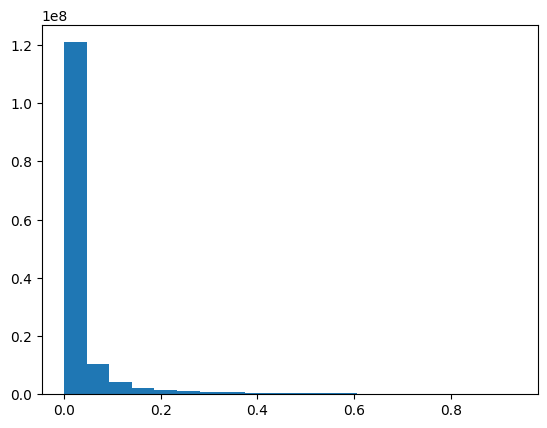

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000